<a href="https://colab.research.google.com/github/AltoTenor/Perfect_Italian_Domination/blob/main/FYP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches



In [38]:
nx.__version__

'3.4.2'

## PID Solving Algorithms

### $\Delta_2$ Split Graphs where weighted graph is Isomorphic to Path Graphs


In [39]:
class Delta2Split_IsoPath:

    ''' Constructor for the class '''
    def __init__(self, n, pendant_weights, nbr_weights ):
        # Adding required nodes
        self.n = n
        self.node_size = [300]*n + [i*50+300 for i in pendant_weights] + [i*50+300 for i in nbr_weights]
        self.G = nx.complete_graph(n)
        extra = [i+n for i in range(n)]
        extra += [i+2*n for i in range(n-1)]
        pos = {}
        self.G.add_nodes_from(extra)

        # Adding required edges
        for node in range(n):
            self.G.add_edge(node,node+n)
        for i in range(n-1):
            self.G.add_edge(i,i+2*n)
            self.G.add_edge(i+1,i+2*n)

        # Setting up the clique attributes and position
        for i in range(n):
            self.G.nodes[i]["cardinality"] = 1
            self.G.nodes[i]["name"] = f"$v_{{{i}}}$"
            self.G.nodes[i]["pidf"] = -1
            pos[i] = [0,-(i*2)]

        # Setting up the pendant attributes and position
        for i in range(n):
            self.G.nodes[i+n]["cardinality"] = pendant_weights[i]
            self.G.nodes[i+n]["name"] = f"$P_{{{i}}}$"
            self.G.nodes[i+n]["pidf"] = -1
            pos[i+n] = [-2,-(i*2)]

        # Setting up the neighbourhood attributes and position
        for i in range(n-1):
            self.G.nodes[i+2*n]["name"] = f"$N_{{{i},{i+1}}}$"
            self.G.nodes[i+2*n]["cardinality"] = nbr_weights[i]
            self.G.nodes[i+2*n]["pidf"] = -1
            pos[i+2*n] = [2,-(2*i+1)]

        # Setting up labels
        self.pos = pos
        self.label_pos = {}
        for k,[x,y] in self.pos.items():
            self.label_pos[k] = [x+.2,y+.5]

    ''' Function to add labels to graph '''
    def add_labels(self, pidf=False, name=False):
        if pidf and name:
            self.labels = {i: f"{data['name']}: ({data['cardinality']}, {data['pidf']})" for i, data in self.G.nodes(data=True)}
        elif pidf:
            self.labels = {i: f"({data['cardinality']}, {data['pidf']})" for i, data in self.G.nodes(data=True)}
        elif name:
            self.labels = {i: f"{data['name']}: {data['pidf']}" for i, data in self.G.nodes(data=True)}
        else:
            self.labels = {i: f"{data['cardinality']}" for i, data in self.G.nodes(data=True)}
        nx.draw_networkx_labels(self.G, self.label_pos, labels=self.labels)

    ''' Function to draw the graph '''
    def draw(self):
        fig = plt.figure(figsize=(15,self.n))
        ax = fig.gca()
        ax.set_title("Path Induced Clique Split Graph")
        rect = Rectangle(
            (-1/2, -2*self.n+1),  # Bottom-left corner
            1,
            2*self.n,
            linewidth=1,
            edgecolor="black",
            facecolor=(0.5, 0.5, 0.5, 0.5),  # RGBA for translucent gray
            linestyle="dashed"  # Dotted border
        )
        ax.add_patch(rect)

        # node colors accd to pidf
        color = {
            0 : 'gray',
            1 : '#5F8B9A',
            2 : 'darkblue',
            -1 : '#A13C3C'
        }
        node_colors = [ color[data['pidf']] for i, data in self.G.nodes(data=True) ]
        nx.draw(self.G, with_labels=False, node_size= self.node_size, pos=self.pos, node_color=node_colors)

    ''' Functions to get cardinalities of Neighbours'''
    def ordN(self, i):
        return self.G.nodes[i+2*self.n]['cardinality']

    ''' Functions to get cardinalities of Pendants'''
    def ordP(self, i):
        return self.G.nodes[i+self.n]['cardinality']

    ''' Function to solve the PIDF '''
    def solve_pidf(self):
        self.ans = [-1]*3*self.n
        PID = 0
        for i in range(self.n):
            self.ans[i], PID = self.assign_val(i, PID)
            # print(self.ans)

        '''Assigning the attribute pidf for every node to display'''
        # For clique vertices
        for i in range(self.n):
            self.G.nodes[i]["pidf"] = self.ans[i]

        # For pendant vertices
        for i in range(self.n):
            if self.G.nodes[i]["pidf"] == 2:
                self.G.nodes[i+self.n]["pidf"] = 0
            else:
                self.G.nodes[i+self.n]["pidf"] = 1

        # For neighbourhood vertices
        for i in range(self.n-1):
            if self.G.nodes[i]["pidf"] == 2 or self.G.nodes[i+1]["pidf"] == 2:
                self.G.nodes[i+2*self.n]["pidf"] = 1
            else:
                self.G.nodes[i+2*self.n]["pidf"] = 0
        return PID, self.ans

    ''' Function to assign values '''
    def assign_val(self, i, PID):

        arr_copy = self.ans.copy()
        # When 1 is assigned
        PID_1 = (1 + self.ordP(i))
        if i == 0:
            pass
        elif self.ans[i-1] == 1:
            PID_1 += PID
        # Propagate up
        elif self.ans[i-1] == 2:
            PID_1 += self.recalc(i-1, PID)

        # When 2 is assigned
        PID_2 = 2
        # If not first vertex add neighbour set size also
        if i!= 0 :
            PID_2 += (PID + self.ordN(i-1))

        # Return Minimum
        if PID_1 < PID_2:
            return 1, PID_1
        else:
            self.ans = arr_copy
            return 2, PID_2

    ''' Function to recalculate'''
    def recalc(self, k, PID):
        # Graph on first vertex
        if k == -1:
            return 0
        # If previous vertex is assigned 1 no need to recalc
        if self.ans[k] == 1:
            return PID
        # Keep 2 as a 2
        x2 = PID + self.ordN(k)

        arr_copy = self.ans.copy()

        # Change 2 to a 1
        x1 = self.recalc(k-1, PID - 2 - self.ordN(k-1)) + 1 + self.ordP(k)

        # Return min
        if x2 < x1:
            self.ans = arr_copy
            self.ans[k] = 2
            return x2
        else:
            self.ans[k] = 1
            return x1

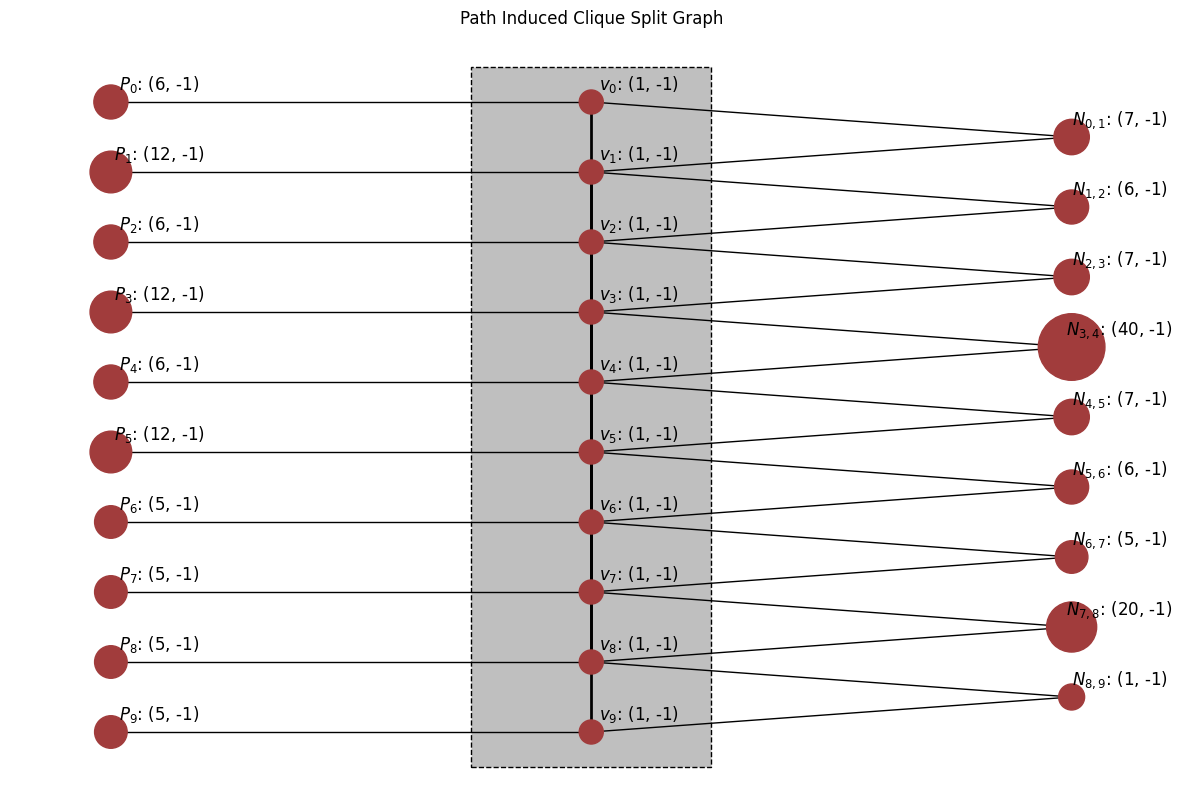

In [40]:
x = Delta2Split_IsoPath( 10, [6, 12, 6, 12, 6, 12, 5,5,5,5 ], [7,6,7,40,7,6,5,20, 1] )
x.draw()
x.add_labels(1,1)

33

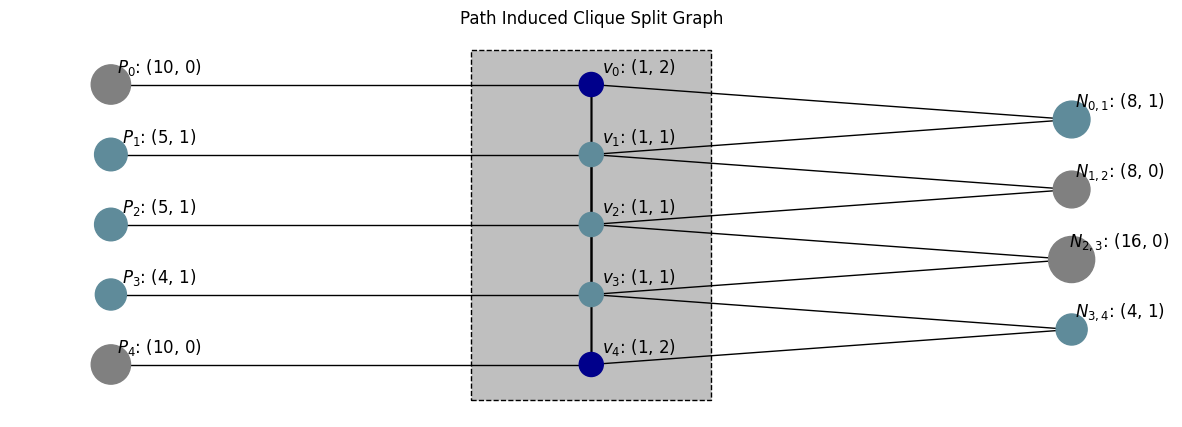

In [41]:
p = [10, 5, 5, 4, 10]
nbr = [8, 8, 16, 4]
# p.reverse()
# nbr.reverse()
x = Delta2Split_IsoPath( len(p), p, nbr)
pid, pidf = x.solve_pidf()
x.draw()
x.add_labels(1,1)
pid

### $\Delta_2$ Split Graphs Brute Force

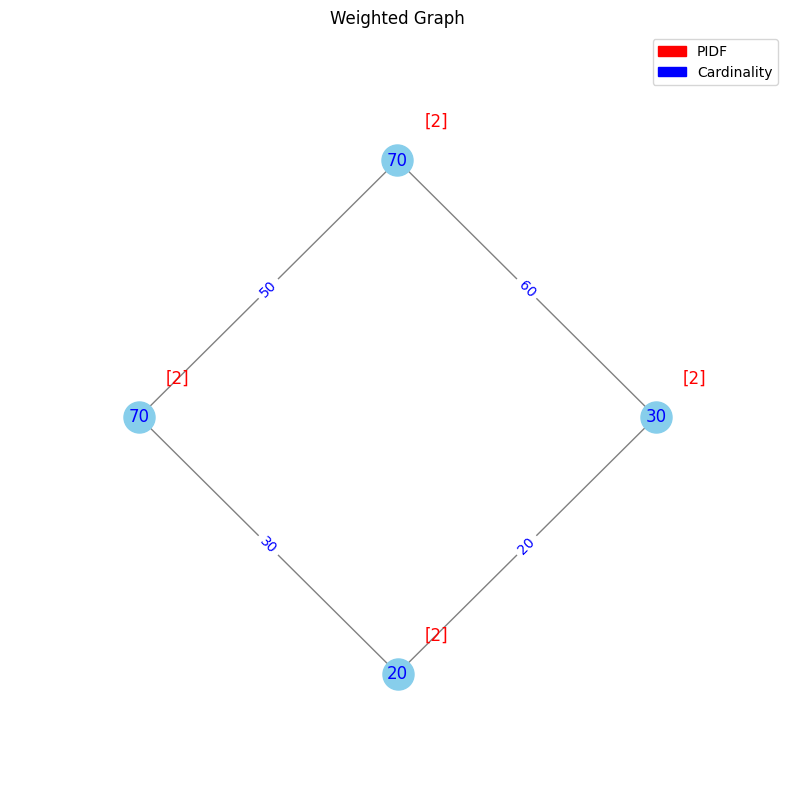


The final PID is:  168


[2, 2, 2, 2]

In [42]:
class Delta2_Weighted:
    ''' constructor '''
    def __init__(self, clique_size, weights ):
        self.clique_size = clique_size
        self.G = nx.Graph()

        # Copying upper triangle to lower
        for i in range(self.clique_size):
            for j in range(self.clique_size):
                if i < j:
                    weights[j][i] = weights[i][j]

        # Adding nodes with Pendant Weights
        for i in range(self.clique_size):
            self.G.add_node(i, weight = weights[i][i])

        # Adding edges with Neighbour Weights
        for i in range(self.clique_size):
            for j in range(i+1, self.clique_size):
                if i != j and weights[i][j]!=0:
                    self.G.add_edge(i, j, weight= weights[i][j] )

    '''Draws the weighted graph representation'''
    def draw(self, with_PID = False):
        # Draw the graph (nodes and edges)
        pos = nx.circular_layout(self.G)
        fig = plt.figure(figsize=(10, 10), dpi=100)
        ax = fig.add_subplot(1, 1, 1)

        # Set parameters for the axis
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.set_title("Weighted Graph")

        # Actual Graph
        nx.draw(self.G, pos,
                with_labels=False,
                node_color='skyblue',
                node_size=500,
                edge_color='gray')

        # Extract and draw edge weights
        edge_labels = nx.get_edge_attributes(self.G, 'weight')
        nx.draw_networkx_edge_labels(   self.G,
                                        pos,
                                        edge_labels=edge_labels,
                                        font_color='blue' )

        # Shifted positions to make the vertex labels appear a little cleaner
        pos_shifted = pos
        for key in pos_shifted:
            for j in range(len(pos_shifted[key])):
                pos_shifted[key][j] += 0

        node_labels = nx.get_node_attributes(self.G, 'weight')
        nx.draw_networkx_labels(self.G,
                                pos_shifted,
                                labels=node_labels,
                                font_color='blue')

        # Empty list for legend
        handles = []
        # Function to add the PID Numbers also
        if with_PID:
            self.draw_pidf(pos_shifted)
            handles += [mpatches.Patch(color='red', label='PIDF')]

        # Create legend handles for the two categories
        handles += [mpatches.Patch(color='blue', label='Cardinality')]

        plt.legend(handles=handles)

        plt.show()

    def draw_pidf(self, pos_shifted):
        # Generating labels
        labels = {i: f"[{self.ans_pidf[i]}]"
                  for i, data in self.G.nodes(data=True)}

        # Shifted positions to make the vertex labels appear a little cleaner
        for key in pos_shifted:
            for j in range(len(pos_shifted[key])):
                pos_shifted[key][j] += .15

        nx.draw_networkx_labels(self.G, pos_shifted, labels=labels, font_color='red')


    ''' Brute force 3^n algorithm '''
    # Main Function for initiating the brute force algorithm
    def brute_force_PID(self):
        self.clique_pidf = [1]*self.clique_size
        self.ans = 100000
        self.ans_pidf = [] #Some large Infinity
        self.backtrack(0)
        return (self.ans, self.ans_pidf)

    # For backtracking and recursive call
    def backtrack( self, k ):
        if k == self.clique_size:
            calculated_pidf = self.calc_pidf()
            # print(calculated_pidf)
            # print(self.clique_pidf)
            if ( self.ans >= calculated_pidf ):
                self.ans = calculated_pidf
                self.ans_pidf = self.clique_pidf.copy()
            return
        else:
            self.backtrack(k+1)
            self.clique_pidf[k] = 2
            self.backtrack(k+1)
            self.clique_pidf[k] = 1
            return

    # For a given set of PIDF values calculate what the value of PID
    def calc_pidf(self):
        pidf = 0
        # Adding the PIDF for clique vertices
        for i in range(self.clique_size):
            pidf += self.clique_pidf[i]

        # Adding the PIDF for Independent Set Vertices - Pendants
        for i in range(self.clique_size):
            if self.clique_pidf[i] != 2:
                pidf += self.G.nodes[i]['weight']

        # Adding the PIDF for Independent Set Vertices - Neighbours
        for i in range(self.clique_size):
            for j in range(self.clique_size):
                if i<j and j in self.G[i] and ( self.clique_pidf[i] == 2 or self.clique_pidf[j] == 2 ):
                    pidf += self.G.edges[i,j]['weight']

        return pidf

t = 20
r = 20

# weights = [
#     [r, t, 0, 0, r],
#     [0, 50, t, 0, 0],
#     [0, 0, r, t, 0],
#     [0, 0, 0, r, t],
#     [0, 0, 0, 0, r],
# ]

weights = [
     [30, 60, 0, 20],
     [30, 70, 50, 0],
     [0, 50, 70, 30],
     [20, 0, 60, 20]
    ]


x = Delta2_Weighted(len(weights), weights)
ans, pidf = x.brute_force_PID()
x.draw(with_PID = True)
print("\nThe final PID is: ", ans)
pidf

In [43]:
import pandas as pd
import random
def make_random_int(min=0, max=100):
    return int(random.random()*(max-min)+min)

def find_random_weights(n):
    weights = [[0]*n for _ in range(n)]
    for i in range(n):
        weights[i][i] = make_random_int()
    for i in range(n-1):
        weights[i][i+1] = make_random_int()

    x = Delta2_Weighted(len(weights), weights)
    ans, pidf = x.brute_force_PID()

    if pidf == [2] * n :
        weights[0][n-1] = make_random_int()
        x = Delta2_Weighted(len(weights), weights)
        ans, pidf = x.brute_force_PID()

        if pidf == [1] * n :
            print(pd.DataFrame(weights))
            return False
        return True
    return True

while (find_random_weights(4)):
    pass

    0   1   2   3
0  77  64   0  35
1  64   4  72   0
2   0  72  82  86
3  35   0  86  96


### $\Delta_2$ Split Graph Isomorphic Cycle Algorithms

In [44]:
class Delta2Split_IsoCycle:

    ''' Constructor for the class '''
    def __init__(self, n, pendant_weights, nbr_weights ):
        # Adding required nodes
        self.n = n
        self.node_size = [300]*n + [i*50+300 for i in pendant_weights] + [i*50+300 for i in nbr_weights]
        self.G = nx.complete_graph(n)
        extra = [i+n for i in range(n)]
        extra += [i+2*n for i in range(n)]
        pos = {}
        self.G.add_nodes_from(extra)

        # Adding required edges
        for node in range(n):
            self.G.add_edge(node,node+n)
        for i in range(n):
            self.G.add_edge(i,i+2*n)
            self.G.add_edge((i+1)%n,i+2*n)

        # Setting up the clique attributes and position
        for i in range(n):
            self.G.nodes[i]["cardinality"] = 1
            self.G.nodes[i]["name"] = f"$v_{{{i}}}$"
            self.G.nodes[i]["pidf"] = -1
            pos[i] = [0,-(i*2)]

        # Setting up the pendant attributes and position
        for i in range(n):
            self.G.nodes[i+n]["cardinality"] = pendant_weights[i]
            self.G.nodes[i+n]["name"] = f"$P_{{{i}}}$"
            self.G.nodes[i+n]["pidf"] = -1
            pos[i+n] = [1.3,-(i*2)]

        # Setting up the neighbourhood attributes and position
        for i in range(n):
            self.G.nodes[i+2*n]["name"] = f"$N_{{{i},{(i+1)%n}}}$"
            self.G.nodes[i+2*n]["cardinality"] = nbr_weights[i]
            self.G.nodes[i+2*n]["pidf"] = -1
            pos[i+2*n] = [.8, -(2*i+1)]

        # Setting up the last neighbours position
        pos[3*n-1] = [-.8, 1-n]

        # Setting up labels
        self.pos = pos
        self.label_pos = {}
        for k,[x,y] in self.pos.items():
            self.label_pos[k] = [x,y+.6]

    ''' Function to add labels to graph '''
    def add_labels(self, pidf=False, name=False):
        if pidf and name:
            self.labels = {i: f"{data['name']}: ({data['cardinality']}, {data['pidf']})" for i, data in self.G.nodes(data=True)}
        elif pidf:
            self.labels = {i: f"({data['cardinality']}, {data['pidf']})" for i, data in self.G.nodes(data=True)}
        elif name:
            self.labels = {i: f"{data['name']}: {data['pidf']}" for i, data in self.G.nodes(data=True)}
        else:
            self.labels = {i: f"{data['cardinality']}" for i, data in self.G.nodes(data=True)}
        nx.draw_networkx_labels(self.G, self.label_pos, labels=self.labels)

    ''' Function to draw the graph '''
    def draw(self):
        fig = plt.figure(figsize=(12, self.n))
        ax = fig.gca()
        ax.set_title("Cycle Induced Clique Split Graph")
        rect = Rectangle(
            (-1/2, -2*self.n+1),  # Bottom-left corner
            1,
            2*self.n,
            linewidth=1,
            edgecolor="black",
            facecolor=(0.5, 0.5, 0.5, 0.5),  # RGBA for translucent gray
            linestyle="dashed"  # Dotted border
        )
        ax.add_patch(rect)

        # node colors accd to pidf
        color = {
            0 : 'gray',
            1 : '#5F8B9A',
            2 : 'darkblue',
            -1 : '#A13C3C'
        }
        node_colors = [ color[data['pidf']] for i, data in self.G.nodes(data=True) ]
        nx.draw(self.G, with_labels=False, node_size= self.node_size, pos=self.pos, node_color=node_colors)

    ''' Functions to get cardinalities of Neighbours'''
    def ordN(self, i):
        return self.G.nodes[i+2*self.n]['cardinality']

    ''' Functions to get cardinalities of Pendants'''
    def ordP(self, i):
        return self.G.nodes[i+self.n]['cardinality']

    ''' Function to solve the PIDF '''
    def solve_pidf(self):
        self.ans = [-1]*3*self.n
        PID = 0
        for i in range(self.n):
            self.ans[i], PID = self.assign_val(i, PID)

        # For the last neighbour which makes it a cycle
        if ( self.ans[0] == 2 and self.ans[self.n-1] == 1 ):
            PID = self.recalcDown(0, PID)

        elif ( self.ans[0] == 1 and self.ans[self.n-1] == 2 ):
            PID = self.recalcUp(self.n-1, PID)

        elif ( self.ans[0] == 2 and self.ans[self.n-1] == 2):
            # Keep both 2 as a 2s
            op2 = PID + self.ordN(self.n-1)
            copy = self.ans.copy()

            # Force and change both 2s to 1s
            # Dont add new neighbour in this case
            self.ans[0] = 1
            op1 = self.recalcDown(1, PID - 2 - self.ordN(0) ) + 1 + self.ordP(0)
            # Non intersecting case - lowermost 2 not converted to 1
            if ( self.ans[self.n-1] == 2 ):
                self.ans[self.n-1] = 1
                op1 = self.recalcUp(self.n-2, op1 - 2 - self.ordN(self.n-2) ) + 1 + self.ordP(self.n-1)

            if op2 <= op1:
                self.ans = copy

            PID = min(op1, op2)

        '''Assigning the attribute pidf for every node to display'''
        # For clique vertices
        for i in range(self.n):
            self.G.nodes[i]["pidf"] = self.ans[i]


        # For pendant vertices
        for i in range(self.n):
            if self.G.nodes[i]["pidf"] == 2:
                self.G.nodes[i+self.n]["pidf"] = 0
            else:
                self.G.nodes[i+self.n]["pidf"] = 1

        # For neighbourhood vertices
        for i in range(self.n):
            if self.G.nodes[i]["pidf"] == 2 or self.G.nodes[(i+1)%self.n]["pidf"] == 2:
                self.G.nodes[i+2*self.n]["pidf"] = 1
            else:
                self.G.nodes[i+2*self.n]["pidf"] = 0
        return PID, self.ans

    ''' Function to assign values '''
    def assign_val(self, i, PID):

        arr_copy = self.ans.copy()
        # When 1 is assigned
        PID_1 = (1 + self.ordP(i))
        if i == 0:
            pass
        elif self.ans[i-1] == 1:
            PID_1 += PID
        # Propagate up
        elif self.ans[i-1] == 2:
            PID_1 += self.recalcUp(i-1, PID)

        # When 2 is assigned
        PID_2 = 2
        # If not first vertex add neighbour set size also
        if i!= 0 :
            PID_2 += (PID + self.ordN(i-1))

        # Return Minimum
        if PID_1 < PID_2:
            return 1, PID_1
        else:
            self.ans = arr_copy
            return 2, PID_2

    ''' Function to recalculate upwards'''
    def recalcUp(self, k, PID):
        # Graph on first vertex
        if k == -1:
            return 0
        # If previous vertex is assigned 1 no need to recalc
        if self.ans[k] == 1:
            return PID
        # Keep 2 as a 2
        x2 = PID + self.ordN(k)

        arr_copy = self.ans.copy()

        # Change 2 to a 1
        x1 = self.recalcUp(k-1, PID - 2 - self.ordN(k-1)) + 1 + self.ordP(k)

        # Return min
        if x2 < x1:
            self.ans = arr_copy
            self.ans[k] = 2
            return x2
        else:
            self.ans[k] = 1
            return x1

    ''' Function to recalculate downwards'''
    def recalcDown(self, k, PID):
        # Graph on first vertex
        if k == self.n:
            return 0
        # If previous vertex is assigned 1 no need to recalc
        if self.ans[k] == 1:
            return PID
        # Keep 2 as a 2
        x2 = PID + self.ordN((k-1)%self.n)

        arr_copy = self.ans.copy()

        # Change 2 to a 1
        x1 = self.recalcDown(k+1, PID - 2 - self.ordN(k)) + 1 + self.ordP(k)

        # Return min
        if x2 < x1:
            self.ans = arr_copy
            self.ans[k] = 2
            return x2
        else:
            self.ans[k] = 1
            return x1

168

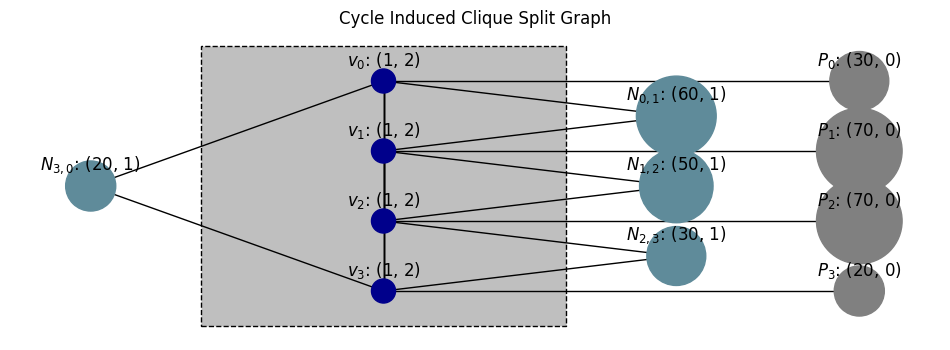

In [45]:
dg = Delta2Split_IsoCycle( 4, [30, 70, 70, 20], [60,50,30,20] )
pid, pidf = dg.solve_pidf()
dg.draw()
dg.add_labels(1,1)
pid

## Verification of Algorithm

### Path Algorithm Verification with Brute Force

In [46]:
%%time
passed = True
for i in range(100000):
    # Checking
    a = make_random_int()
    b = make_random_int()
    c = make_random_int()
    d = make_random_int()
    e = make_random_int()
    x = make_random_int()
    y = make_random_int()
    z = make_random_int()
    t = make_random_int()
    weights = [
        [ a, x, 0, 0, 0],
        [ 0, b, y, 0, 0],
        [ 0, 0, c, z, 0],
        [ 0, 0, 0, d, t],
        [ 0, 0, 0, 0, e]
    ]

    dg1 = Delta2_Weighted(len(weights), weights)
    ans, pidf = dg1.brute_force_PID()

    dg = Delta2Split_IsoPath( 5, [a,b,c,d,e], [x,y,z,t] )
    pid, pidf1 = dg.solve_pidf()
    if (ans != pid and pidf==pidf1):
        passed = False
        print(i, weights)
        break
if passed:
    print("Algorithm matches with Brute Force")

Algorithm matches with Brute Force
CPU times: user 41.5 s, sys: 189 ms, total: 41.7 s
Wall time: 41.5 s


### Cycle Algorithm Verification with Brute Force

In [47]:
%%time
passed = True
for i in range(100000):
    # Checking
    a = make_random_int()
    b = make_random_int()
    c = make_random_int()
    d = make_random_int()
    e = make_random_int()
    x = make_random_int()
    y = make_random_int()
    z = make_random_int()
    t = make_random_int()
    u = make_random_int()
    weights = [
        [ a, x, 0, 0, u],
        [ 0, b, y, 0, 0],
        [ 0, 0, c, z, 0],
        [ 0, 0, 0, d, t],
        [ 0, 0, 0, 0, e]
    ]

    dg1 = Delta2_Weighted(len(weights), weights)
    ans, pidf = dg1.brute_force_PID()

    dg = Delta2Split_IsoCycle( 5, [a,b,c,d,e], [x,y,z,t,u] )
    pid, pidf1 = dg.solve_pidf()
    if (ans != pid and pidf==pidf1):
        passed = False
        print(i, weights)
        break
if passed:
    print("Algorithm matches with Brute Force")

Algorithm matches with Brute Force
CPU times: user 42.3 s, sys: 199 ms, total: 42.5 s
Wall time: 42.4 s


## Time and Space Complexity Analysis

In [48]:
import time
import psutil
import os

# Get process ID of the current notebook
process = psutil.Process(os.getpid())
def compare_times(N):
    vals = [-1]*(2*N)

    # Setting up random values
    for i in range(2*N):
        vals[i] = make_random_int()

    mem0 = process.memory_info().rss
    time0 = time.time()

    # Performing Brute Force Algorithm on Path
    if N <= 20:
        weights = [[0]*N for _ in range(N)]
        for i in range(N):
            weights[i][i] = vals[i]
            weights[i][(i+1)%N] = vals[i+N]
        dg1 = Delta2_Weighted(len(weights), weights)
        ans, pidf = dg1.brute_force_PID()

    mem1 = process.memory_info().rss
    time1 = time.time()

    # Performing Split Graph Algorithm on Cycle
    dg = Delta2Split_IsoCycle( N, vals[:N], vals[N:] )
    ans, pidf = dg.solve_pidf()

    mem2 = process.memory_info().rss
    time2 = time.time()

    # Performing Split Graph Algorithm on PAth
    dg2 = Delta2Split_IsoPath( N, vals[:N], vals[N:-1] )
    ans, pidf = dg2.solve_pidf()

    mem3 = process.memory_info().rss
    time3 = time.time()

    return (    [N, time1 - time0, time2 - time1, time3 - time2],
                [N, (mem1-mem0) >> 20, (mem2-mem1) >> 20, (mem3-mem2) >> 20]
             )

In [49]:
itr = [1, 10, 20, 50, 100, 1000, 5000, 10000, 15000]
data = [ compare_times(i) for i in itr ]

In [50]:
df = pd.DataFrame([i[0] for i in data], columns=['Iterations','Brute Force', 'Iso Cycle', 'Iso Path'])
df = df.set_index('Iterations')
df['Brute Force'] = df['Brute Force'].astype(object)
df.loc[50:, 'Brute Force'] = 'N/A'
print("Time taken by the algorithms ( in seconds ): ")
print("---")
df

Time taken by the algorithms ( in seconds ): 
---


,Brute Force,Iso Cycle,Iso Path
Iterations,,,
1,0.000101,0.000338,0.000312
10,0.037698,0.000219,0.000314
20,154.164921,0.000629,0.000699
50,N/A,0.001740,0.001692
100,N/A,0.005151,0.005760
1000,N/A,0.553488,0.409100
5000,N/A,13.778394,12.626025
10000,N/A,56.209812,64.798195
15000,N/A,138.646602,167.043132


In [51]:
df = pd.DataFrame([i[1] for i in data], columns=['Iterations','Brute Force', 'Iso Cycle', 'Iso Path'])
df = df.set_index('Iterations')
df['Brute Force'] = df['Brute Force'].astype(object)  # Convert column to string type
df.loc[50:, 'Brute Force'] = 'N/A'
print("Space taken by the algorithms ( in MB ): ")
print("---")
df

Space taken by the algorithms ( in MB ): 
---


,Brute Force,Iso Cycle,Iso Path
Iterations,,,
1,0,0,0
10,0,0,0
20,0,0,0
50,N/A,0,0
100,N/A,0,0
1000,N/A,0,29
5000,N/A,723,778
10000,N/A,2979,4866
15000,N/A,11347,15387
